In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence

#Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_theme(style="whitegrid")

In [13]:
df = pd.read_csv('../Data Source/final_merge.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   county                      3076 non-null   object 
 1   state                       3076 non-null   object 
 2   ruca                        3073 non-null   float64
 3   brfss_access2_ageadjprv     3076 non-null   float64
 4   brfss_checkup_ageadjprv     3076 non-null   float64
 5   brfss_csmoking_ageadjprv    3076 non-null   float64
 6   brfss_depression_ageadjprv  3076 non-null   float64
 7   brfss_diabetes_ageadjprv    3076 non-null   float64
 8   brfss_ghlth_ageadjprv       3076 non-null   float64
 9   brfss_mhlth_ageadjprv       3076 non-null   float64
 10  brfss_obesity_ageadjprv     3076 non-null   float64
 11  pct_ed_lt9                  3076 non-null   float64
 12  pct_ed_9_12                 3076 non-null   float64
 13  pct_ed_hs                   3076 

In [18]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    'pct_sex_female',
    'pct_occ_unemp',
    'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    'pct_tp_veh_3',
    'bb_int_struct',
    'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

# Linear Regression and Assumptions Check

Each iteration of the linear regression model fit until final is to reduce variables that exceed VIF threshold (VIF > 5) and check the assumptions of linear regression.

In [19]:
model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

c:\ProgramData\miniconda3\envs\ds_mf\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Tolerance,features
0,1.000,1.000,const
1,3.040,0.330,pct_dg_bb_int
2,7.600,0.130,brfss_access2_ageadjprv
3,2.900,0.350,brfss_checkup_ageadjprv
4,14.970,0.070,brfss_csmoking_ageadjprv
5,5.080,0.200,brfss_depression_ageadjprv
6,24.370,0.040,brfss_ghlth_ageadjprv
7,12.890,0.080,brfss_mhlth_ageadjprv
8,3.540,0.280,brfss_obesity_ageadjprv
9,2071.190,0.000,pct_ed_lt9


High VIF values in the model. Will reduce varibles one by one until all VIF values are below 5.

In [20]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    'pct_tp_veh_3',
    'bb_int_struct',
    'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,3.040,0.330,pct_dg_bb_int
2,7.600,0.130,brfss_access2_ageadjprv
3,2.900,0.350,brfss_checkup_ageadjprv
4,14.970,0.070,brfss_csmoking_ageadjprv
5,5.080,0.200,brfss_depression_ageadjprv
6,24.370,0.040,brfss_ghlth_ageadjprv
7,12.890,0.080,brfss_mhlth_ageadjprv
8,3.540,0.280,brfss_obesity_ageadjprv
9,2071.190,0.000,pct_ed_lt9


In [21]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,3.040,0.330,pct_dg_bb_int
2,7.590,0.130,brfss_access2_ageadjprv
3,2.900,0.350,brfss_checkup_ageadjprv
4,14.970,0.070,brfss_csmoking_ageadjprv
5,5.070,0.200,brfss_depression_ageadjprv
6,24.340,0.040,brfss_ghlth_ageadjprv
7,12.890,0.080,brfss_mhlth_ageadjprv
8,3.540,0.280,brfss_obesity_ageadjprv
9,2071.110,0.000,pct_ed_lt9


In [22]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,3.040,0.330,pct_dg_bb_int
2,7.590,0.130,brfss_access2_ageadjprv
3,2.890,0.350,brfss_checkup_ageadjprv
4,14.970,0.070,brfss_csmoking_ageadjprv
5,5.070,0.200,brfss_depression_ageadjprv
6,24.330,0.040,brfss_ghlth_ageadjprv
7,12.890,0.080,brfss_mhlth_ageadjprv
8,3.540,0.280,brfss_obesity_ageadjprv
9,2071.110,0.000,pct_ed_lt9


In [23]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    #'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,3.030,0.330,pct_dg_bb_int
2,7.590,0.130,brfss_access2_ageadjprv
3,2.890,0.350,brfss_checkup_ageadjprv
4,14.970,0.070,brfss_csmoking_ageadjprv
5,5.070,0.200,brfss_depression_ageadjprv
6,24.330,0.040,brfss_ghlth_ageadjprv
7,12.870,0.080,brfss_mhlth_ageadjprv
8,3.540,0.280,brfss_obesity_ageadjprv
9,3.130,0.320,pct_ed_lt9


In [24]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    #'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    #'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,3.030,0.330,pct_dg_bb_int
2,7.580,0.130,brfss_access2_ageadjprv
3,2.880,0.350,brfss_checkup_ageadjprv
4,14.960,0.070,brfss_csmoking_ageadjprv
5,5.070,0.200,brfss_depression_ageadjprv
6,24.290,0.040,brfss_ghlth_ageadjprv
7,12.870,0.080,brfss_mhlth_ageadjprv
8,3.540,0.280,brfss_obesity_ageadjprv
9,3.130,0.320,pct_ed_lt9


In [25]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    #'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    #'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    #'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,3.020,0.330,pct_dg_bb_int
2,7.550,0.130,brfss_access2_ageadjprv
3,2.860,0.350,brfss_checkup_ageadjprv
4,14.960,0.070,brfss_csmoking_ageadjprv
5,5.070,0.200,brfss_depression_ageadjprv
6,24.280,0.040,brfss_ghlth_ageadjprv
7,12.800,0.080,brfss_mhlth_ageadjprv
8,3.520,0.280,brfss_obesity_ageadjprv
9,3.130,0.320,pct_ed_lt9


In [26]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    #'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    #'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    #'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    #'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))


,VIF,Tolerance,features
0,1.000,1.000,const
1,2.980,0.340,pct_dg_bb_int
2,7.430,0.130,brfss_access2_ageadjprv
3,2.840,0.350,brfss_checkup_ageadjprv
4,13.020,0.080,brfss_csmoking_ageadjprv
5,5.060,0.200,brfss_depression_ageadjprv
6,10.180,0.100,brfss_mhlth_ageadjprv
7,3.270,0.310,brfss_obesity_ageadjprv
8,2.910,0.340,pct_ed_lt9
9,4.150,0.240,pct_ed_9_12


In [27]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    #'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    #'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    #'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    #'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    #'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.970,0.340,pct_dg_bb_int
2,7.400,0.140,brfss_access2_ageadjprv
3,2.830,0.350,brfss_checkup_ageadjprv
4,5.020,0.200,brfss_depression_ageadjprv
5,9.790,0.100,brfss_mhlth_ageadjprv
6,3.060,0.330,brfss_obesity_ageadjprv
7,2.890,0.350,pct_ed_lt9
8,4.140,0.240,pct_ed_9_12
9,1.820,0.550,pct_ed_sc


In [29]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    #'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    #'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    #'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    #'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    #'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    #'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.970,0.340,pct_dg_bb_int
2,2.790,0.360,brfss_checkup_ageadjprv
3,4.960,0.200,brfss_depression_ageadjprv
4,9.650,0.100,brfss_mhlth_ageadjprv
5,3.060,0.330,brfss_obesity_ageadjprv
6,2.890,0.350,pct_ed_lt9
7,4.030,0.250,pct_ed_9_12
8,1.820,0.550,pct_ed_sc
9,1.990,0.500,pct_ed_asc


In [31]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    #'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    #'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    #'brfss_ghlth_ageadjprv',
    #'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    #'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    #'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    #'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.970,0.340,pct_dg_bb_int
2,2.790,0.360,brfss_checkup_ageadjprv
3,2.450,0.410,brfss_depression_ageadjprv
4,3.050,0.330,brfss_obesity_ageadjprv
5,2.880,0.350,pct_ed_lt9
6,3.980,0.250,pct_ed_9_12
7,1.820,0.550,pct_ed_sc
8,1.800,0.560,pct_ed_asc
9,5.690,0.180,pct_ed_b


In [32]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    #'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    #'brfss_csmoking_ageadjprv',
    'brfss_depression_ageadjprv',
    #'brfss_ghlth_ageadjprv',
    #'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    #'pct_ed_hs',
    'pct_ed_sc',
    'pct_ed_asc',
    #'pct_ed_b',
    'pct_ed_gr',
    'pct_age_gte65',
    #'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    'pct_occ_svc',
    'pct_occ_sales',
    'pct_occ_nat_res',
    'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    'pct_tp_veh_1',
    'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    #'ruca_metro',
    'ruca_micro',
    'ruca_small_town',
    'ruca_rural'
]

# Define X and y, center X, and add constant
X = df[iv + covariates]
y = df[dv]
X = X - X.mean()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
display(vif.round(2))

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.930,0.340,pct_dg_bb_int
2,2.790,0.360,brfss_checkup_ageadjprv
3,2.370,0.420,brfss_depression_ageadjprv
4,2.890,0.350,brfss_obesity_ageadjprv
5,2.860,0.350,pct_ed_lt9
6,3.540,0.280,pct_ed_9_12
7,1.780,0.560,pct_ed_sc
8,1.740,0.580,pct_ed_asc
9,4.990,0.200,pct_ed_gr


                      Results: Ordinary least squares
Model:                OLS                      Adj. R-squared:     0.943    
Dependent Variable:   brfss_diabetes_ageadjprv AIC:                4949.6861
Date:                 2024-04-04 09:19         BIC:                5142.6904
No. Observations:     3076                     Log-Likelihood:     -2442.8  
Df Model:             31                       F-statistic:        1650.    
Df Residuals:         3044                     Prob (F-statistic): 0.00     
R-squared:            0.944                    Scale:              0.28965  
----------------------------------------------------------------------------
                            Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------------
const                      10.5643   0.0097 1088.6830 0.0000 10.5453 10.5834
pct_dg_bb_int              -0.0107   0.0021   -5.0811 0.0000 -0.0148 -0.0066
brfss_checkup_ageadjpr

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.930,0.340,pct_dg_bb_int
2,2.790,0.360,brfss_checkup_ageadjprv
3,2.370,0.420,brfss_depression_ageadjprv
4,2.890,0.350,brfss_obesity_ageadjprv
5,2.860,0.350,pct_ed_lt9
6,3.540,0.280,pct_ed_9_12
7,1.780,0.560,pct_ed_sc
8,1.740,0.580,pct_ed_asc
9,4.990,0.200,pct_ed_gr


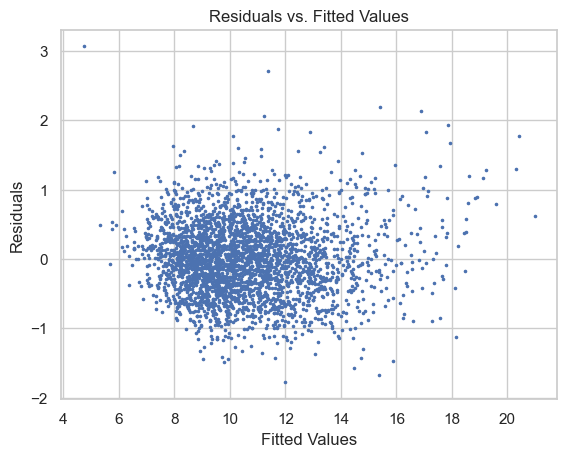

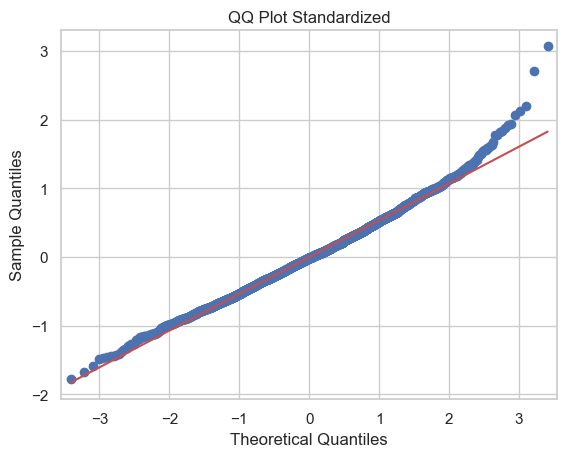

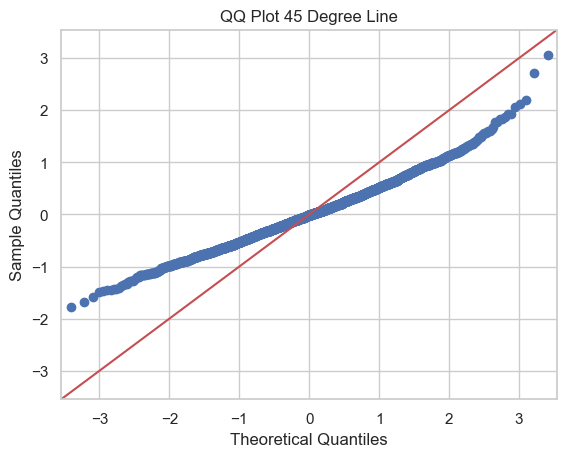

In [33]:
model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

In [34]:
summary_df = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index':'feature'})
print(summary_df)

                       feature   coef  std err        t  P>|t|  [0.025  0.975]
0                        const 10.564    0.010 1088.683  0.000  10.545  10.583
1                pct_dg_bb_int -0.011    0.002   -5.081  0.000  -0.015  -0.007
2      brfss_checkup_ageadjprv  0.058    0.004   15.820  0.000   0.050   0.065
3   brfss_depression_ageadjprv  0.076    0.005   16.660  0.000   0.067   0.085
4      brfss_obesity_ageadjprv  0.110    0.004   30.103  0.000   0.102   0.117
5                   pct_ed_lt9  0.037    0.005    7.781  0.000   0.028   0.046
6                  pct_ed_9_12  0.073    0.005   13.727  0.000   0.062   0.083
7                    pct_ed_sc  0.002    0.003    0.687  0.492  -0.004   0.009
8                   pct_ed_asc -0.017    0.004   -3.886  0.000  -0.025  -0.008
9                    pct_ed_gr -0.022    0.005   -4.891  0.000  -0.031  -0.013
10               pct_age_gte65  0.005    0.003    1.644  0.100  -0.001   0.011
11              pct_race_black  0.051    0.001   44.

In [35]:
#create a equation for the model in latex
def latex_eq(coefficients, dv):
    eq = dv + ' = '
    for i in range(len(coefficients)):
        if i == 0:
            eq += str(round(coefficients[i], 3))
        else:
            eq += ' + ' + str(round(coefficients[i], 3)) + ' ' + str(summary_df['feature'][i])
    return eq

print(latex_eq(results.params, dv[0]))


brfss_diabetes_ageadjprv = 10.564 + -0.011 pct_dg_bb_int + 0.058 brfss_checkup_ageadjprv + 0.076 brfss_depression_ageadjprv + 0.109 brfss_obesity_ageadjprv + 0.037 pct_ed_lt9 + 0.073 pct_ed_9_12 + 0.002 pct_ed_sc + -0.017 pct_ed_asc + -0.022 pct_ed_gr + 0.005 pct_age_gte65 + 0.051 pct_race_black + 0.037 pct_race_aian + 0.074 pct_race_asian + -0.028 pct_race_nhopi + -0.014 pct_race_other + 0.046 pct_eth_hisp + 0.019 pct_sex_male + 0.008 pct_occ_unemp + 0.008 pct_occ_svc + 0.001 pct_occ_sales + -0.008 pct_occ_nat_res + 0.005 pct_occ_prod + 0.027 pct_hlth_unins + 0.117 pct_ses_pov + -0.012 pct_tp_veh_0 + -0.014 pct_tp_veh_1 + -0.015 pct_tp_veh_2 + -0.509 bb_int_struct + 0.027 ruca_micro + -0.009 ruca_small_town + 0.003 ruca_rural


In [36]:
fit_measures = pd.DataFrame()
fit_measures['MAE'] = [mae]
fit_measures['RMSE'] = [rmse]
fit_measures['R2'] = [results.rsquared]
fit_measures['Adj. R2'] = [results.rsquared_adj]
fit_measures['F-statistic'] = [results.fvalue]
fit_measures['p-value'] = [results.f_pvalue]
fit_measures['AIC'] = [results.aic]
fit_measures['BIC'] = [results.bic]
fit_measures['Log-Likelihood'] = [results.llf]
fit_measures['df_resid'] = [results.df_resid]
fit_measures['df_model'] = [results.df_model]

display(fit_measures.round(2))

,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.420,0.540,0.940,0.940,1650.050,0.000,4949.690,5142.690,-2442.840,3044.000,31.000


## Outlier Assessment and Removal 

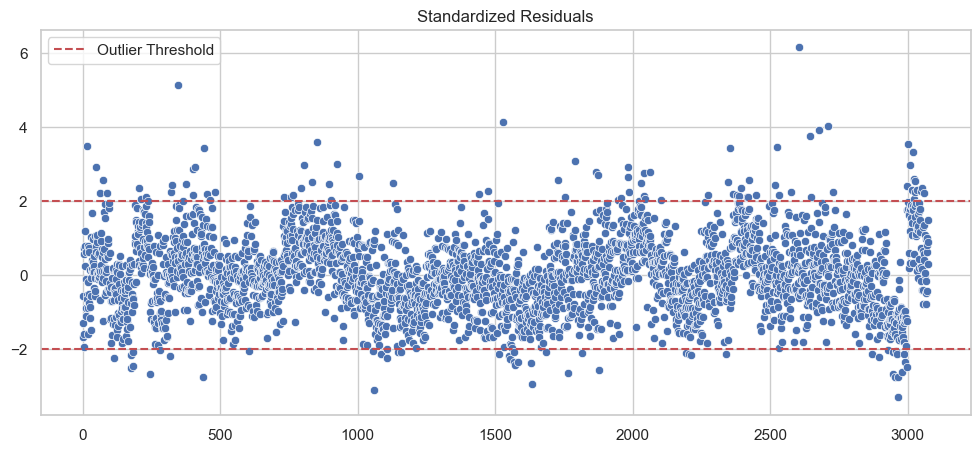

False    2902
True      174
Name: outliers, dtype: int64

0.0013003901170351106
3076


In [37]:
#outlier detection Cook's Distance
influence = OLSInfluence(results)
standardized_residuals = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance

plt.figure(figsize=(12, 5))
sns.scatterplot(x=range(len(standardized_residuals)), y=standardized_residuals)
plt.axhline(y=2, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-2, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.legend()
plt.show()

df_outliers = df.copy()
df_outliers['standardized_residuals'] = standardized_residuals
df_outliers['leverage'] = leverage
df_outliers['cooks_d'] = cooks_d[0]

#identify outliers using Cook's Distance 4/(n-k-1)
df_outliers['outliers'] = df_outliers['cooks_d'] > (4/(len(df_outliers)-len(iv)-1))
df_outliers[df_outliers['outliers'] == True]
display(df_outliers['outliers'].value_counts())

print(4/len(df_outliers))
print(len(df_outliers))


In [38]:
# remove outliers
df_no_outliers = df_outliers[df_outliers['outliers'] == False]
#drop outlier columns
df_no_outliers = df_no_outliers.drop(columns=['standardized_residuals', 'leverage', 'cooks_d', 'outliers'])
# set x and y with outliers removed
X = df_no_outliers[iv + covariates]
y = df_no_outliers[dv]
#center X
X = X - X.mean()
#add constant
X = sm.add_constant(X)

                      Results: Ordinary least squares
Model:                OLS                      Adj. R-squared:     0.948    
Dependent Variable:   brfss_diabetes_ageadjprv AIC:                3883.9952
Date:                 2024-04-04 09:21         BIC:                4075.1362
No. Observations:     2902                     Log-Likelihood:     -1910.0  
Df Model:             31                       F-statistic:        1724.    
Df Residuals:         2870                     Prob (F-statistic): 0.00     
R-squared:            0.949                    Scale:              0.22081  
----------------------------------------------------------------------------
                            Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------------
const                      10.4147   0.0087 1193.9501 0.0000 10.3976 10.4318
pct_dg_bb_int              -0.0086   0.0020   -4.2262 0.0000 -0.0125 -0.0046
brfss_checkup_ageadjpr

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.960,0.340,pct_dg_bb_int
2,2.750,0.360,brfss_checkup_ageadjprv
3,2.360,0.420,brfss_depression_ageadjprv
4,2.730,0.370,brfss_obesity_ageadjprv
5,2.900,0.340,pct_ed_lt9
6,3.750,0.270,pct_ed_9_12
7,1.770,0.560,pct_ed_sc
8,1.750,0.570,pct_ed_asc
9,5.320,0.190,pct_ed_gr


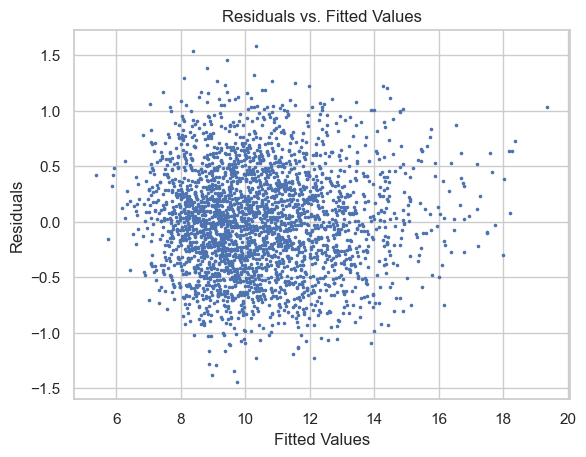

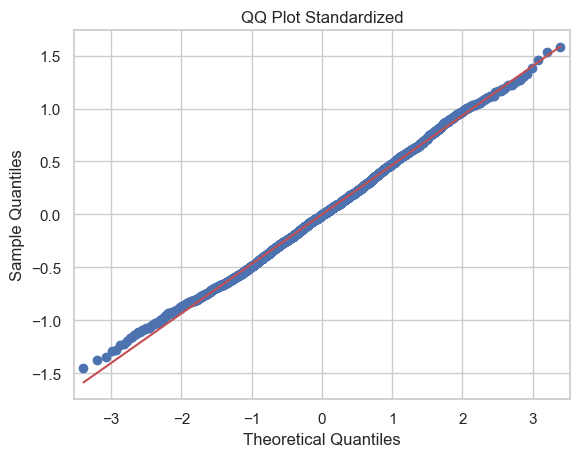

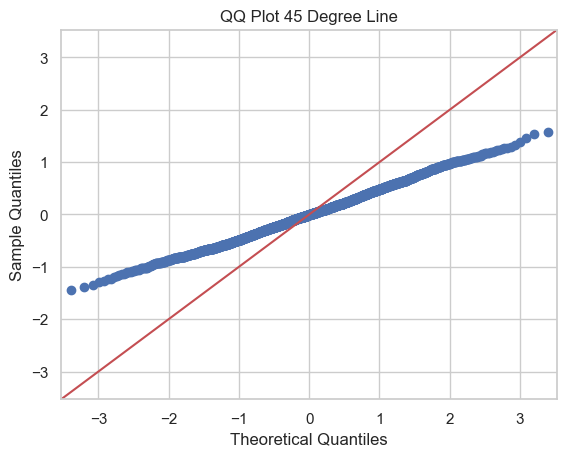

In [39]:
model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

In [40]:
fit_measures_2 = pd.DataFrame()
fit_measures_2['MAE'] = [mae]
fit_measures_2['RMSE'] = [rmse]
fit_measures_2['R2'] = [results.rsquared]
fit_measures_2['Adj. R2'] = [results.rsquared_adj]
fit_measures_2['F-statistic'] = [results.fvalue]
fit_measures_2['p-value'] = [results.f_pvalue]
fit_measures_2['AIC'] = [results.aic]
fit_measures_2['BIC'] = [results.bic]
fit_measures_2['Log-Likelihood'] = [results.llf]
fit_measures_2['df_resid'] = [results.df_resid]
fit_measures_2['df_model'] = [results.df_model]

print('OLS')
display(fit_measures.round(2))
print('OLS with outliers removed')
display(fit_measures_2.round(2))

OLS


,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.420,0.540,0.940,0.940,1650.050,0.000,4949.690,5142.690,-2442.840,3044.000,31.000


OLS with outliers removed


,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.370,0.470,0.950,0.950,1723.910,0.000,3884.000,4075.140,-1910.000,2870.000,31.000


In [41]:
#Outlier remove Model coefficients

summary_df = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index':'feature'})
print(summary_df)

                       feature   coef  std err        t  P>|t|  [0.025  0.975]
0                        const 10.415    0.009 1193.950  0.000  10.398  10.432
1                pct_dg_bb_int -0.009    0.002   -4.226  0.000  -0.013  -0.005
2      brfss_checkup_ageadjprv  0.058    0.003   17.263  0.000   0.052   0.065
3   brfss_depression_ageadjprv  0.079    0.004   18.987  0.000   0.070   0.087
4      brfss_obesity_ageadjprv  0.103    0.003   31.493  0.000   0.097   0.110
5                   pct_ed_lt9  0.035    0.005    6.720  0.000   0.025   0.046
6                  pct_ed_9_12  0.079    0.005   15.259  0.000   0.069   0.090
7                    pct_ed_sc  0.001    0.003    0.155  0.877  -0.006   0.007
8                   pct_ed_asc -0.024    0.004   -5.763  0.000  -0.032  -0.016
9                    pct_ed_gr -0.027    0.004   -6.305  0.000  -0.036  -0.019
10               pct_age_gte65  0.002    0.003    0.578  0.563  -0.004   0.007
11              pct_race_black  0.050    0.001   46.